# ACS2ER in Cart Pole Environment

In [146]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import gym

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))

from lcs.agents.EnvironmentAdapter import EnvironmentAdapter
from lcs.agents.acs2er import ACS2ER, Configuration, ClassifiersList
from lcs.metrics import population_metrics


import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
# papermill params
trials = 2_000
obs_adj_trials=20000
bins = 6
decay=True
biased_exploration=0.05
do_ga=False

## Environment

In [148]:
env = gym.make('CartPole-v0')

Try some random steps to get min/max of each observation

In [149]:
%%time
print(f'Performing {obs_adj_trials} trials with random steps to collect ranges for observation points')

obs_arr = np.zeros((obs_adj_trials, 4))

for i in range(obs_adj_trials):
    env.reset()
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        obs_arr[i, :] = obs

env.close()

Performing 20000 trials with random steps to collect ranges for observation points
Wall time: 6.17 s


For discretization calculate the range between variables

In [150]:
_high = obs_arr.max(axis=0)
_low = obs_arr.min(axis=0)

_range = _high - _low
_range

array([3.15450756, 6.07682336, 0.54089074, 7.05066853])

## Agent configuration

In [151]:
import math
# https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

# working (1, 1, 10, 14)
buckets = (5, 5, 8, 5)


class CartPoleAdapter2(EnvironmentAdapter):

    @classmethod
    def to_genotype(cls, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]

In [152]:
a = CartPoleAdapter2()
CartPoleAdapter2.to_genotype([0, 0, 0, 0])

['2', '2', '4', '2']

In [153]:
class CartPoleObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, bins, low, val_range):
        super().__init__(env)
        self.bins = bins
        self.low = low
        self.range = val_range

    def observation(self, observation):
        return np.round(((observation - self.low) / self.range) * self.bins) \
            .astype(int) \
            .astype(str) \
            .tolist()

In [154]:
def print_cl(cl):
    actions = ['L', 'R']
    action = actions[cl.action]
    
    marked = ''
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [q: {cl.q:.3f}, fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}] {marked}")

## Evaluation metrics

In [155]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])


# collect more metrics
def cp_metrics(agent, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(agent.population)
    metrics.update(population_metrics(agent.population, env))

    return metrics

# ACS2ER Configuration

In [156]:
# The size of ER replay memory buffer
ER_BUFFER_SIZE=1000

# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=100

# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3

cfg = Configuration(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=biased_exploration,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=do_ga,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=5,
            er_buffer_size=ER_BUFFER_SIZE,
            er_min_samples=ER_BUFFER_MIN_SAMPLES,
            er_samples_number=ER_SAMPLES_NUMBER,
            user_metrics_collector_fcn=cp_metrics)

# Experiments

In [157]:
print(f'Running {trials} trials, decay={decay}, bins={bins}\n')
print(cfg)

Running 2000 trials, decay=True, bins=6

{'classifier_length': 4, 'number_of_possible_actions': 2, 'classifier_wildcard': '#', 'metrics_trial_frequency': 5, 'user_metrics_collector_fcn': <function cp_metrics at 0x000002655B6B5D38>, 'fitness_fcn': None, 'do_subsumption': True, 'beta': 0.05, 'theta_i': 0.1, 'theta_r': 0.9, 'epsilon': 0.95, 'u_max': 4, 'theta_exp': 50, 'theta_as': 20, 'use_mlflow': False, 'model_checkpoint_freq': None, 'gamma': 0.99, 'do_pee': False, 'do_ga': False, 'theta_ga': 50, 'mu': 0.03, 'chi': 0.8, 'do_action_planning': False, 'action_planning_frequency': 50, 'initial_q': 0.5, 'biased_exploration_prob': 0.05, 'action_selector': <lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy object at 0x000002655C21AB48>, 'er_buffer_size': 1000, 'er_min_samples': 100, 'er_samples_number': 3}


In [158]:
%%time

agent = ACS2ER(cfg)
wrapped = CartPoleObservationWrapper(env, bins, _low, _range)
metrics_explore = agent.explore(wrapped, trials, decay=decay)
population_explore = agent.population

E:\_ZSSE\other\conda\envs\pyalcs-experiments\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\_ZSSE\other\conda\envs\pyalcs-experiments\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 13, 'reward': 1.0, 'perf_time': 0.19970220000004701, 'avg_fitness': 2.6158645004381857, 'population': 680, 'numerosity': 680, 'reliable': 28}
INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 42, 'reward': 1.0, 'perf_time': 0.7067219000000478, 'avg_fitness': 2.7619566479974176, 'population': 811, 'numerosity': 811, 'reliable': 34}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 31, 'reward': 1.0, 'perf_time': 0.6611671999999089, 'avg_fitness': 3.0819821367787568, 'population': 1045, 'numerosity': 1045, 'reliable': 43}
INFO:lcs.agents.Agent:{'trial': 800, 'steps_in_trial': 23, 'reward':

Wall time: 18min 32s


In [159]:
print(len(population_explore))

1535


In [160]:
for cl in sorted(population_explore, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

#-172 - L - ###3 [q: 0.968, fit: 4.564, r: 4.72, ir: 1.00] (*)
8071 - R - #### [q: 0.999, fit: 4.543, r: 4.55, ir: 1.00] 
9-172 - L - ###3 [q: 0.953, fit: 4.502, r: 4.72, ir: 1.00] 
9-173 - R - ###2 [q: 0.928, fit: 4.479, r: 4.83, ir: 1.00] 
9-152 - L - ##6# [q: 0.992, fit: 4.458, r: 4.50, ir: 1.00] 
9-163 - L - ##7# [q: 1.000, fit: 4.430, r: 4.43, ir: 1.00] 
9#73 - L - #### [q: 1.000, fit: 4.410, r: 4.41, ir: 1.00] 
9-173 - L - #### [q: 1.000, fit: 4.409, r: 4.41, ir: 1.00] 
10151 - R - #### [q: 0.970, fit: 4.399, r: 4.54, ir: 1.00] 
#-163 - L - ##7# [q: 0.990, fit: 4.373, r: 4.42, ir: 1.00] (*)
##73 - L - #### [q: 0.971, fit: 4.268, r: 4.39, ir: 1.00] (*)
##63 - L - ##7# [q: 0.963, fit: 4.239, r: 4.40, ir: 1.00] (*)
10150 - L - ###1 [q: 0.978, fit: 4.198, r: 4.29, ir: 1.00] 
10151 - L - #### [q: 0.959, fit: 4.184, r: 4.36, ir: 1.00] 
9071 - R - #### [q: 0.846, fit: 4.162, r: 4.92, ir: 1.00] 
#-173 - R - ###2 [q: 0.857, fit: 4.135, r: 4.83, ir: 1.00] (*)
#-173 - L - #### [q: 0.935, fi

In [161]:
metrics_df = pd.DataFrame(metrics_explore)
metrics_df.set_index('trial', inplace=True)

## Plots

In [162]:
# for plots
avg_window = int(trials/100)
figsize=(14,6)

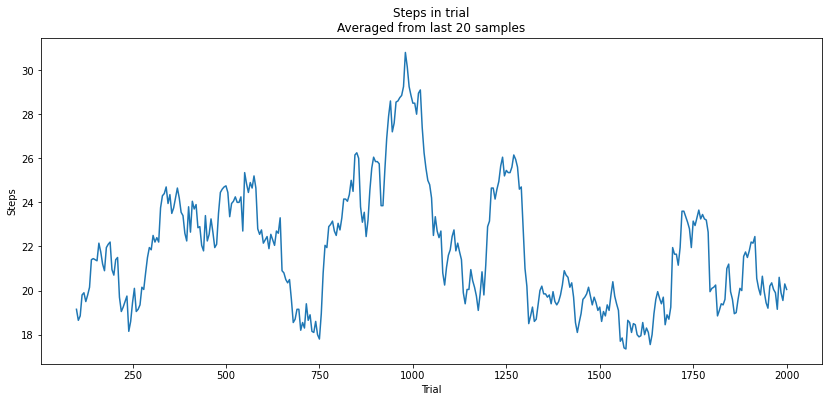

Avg steps 21.7425


In [163]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['steps_in_trial'].rolling(window=avg_window).mean().plot();
ax.set_title(f'Steps in trial\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Steps')

plt.show()

print(f"Avg steps {metrics_df['steps_in_trial'].mean()}")

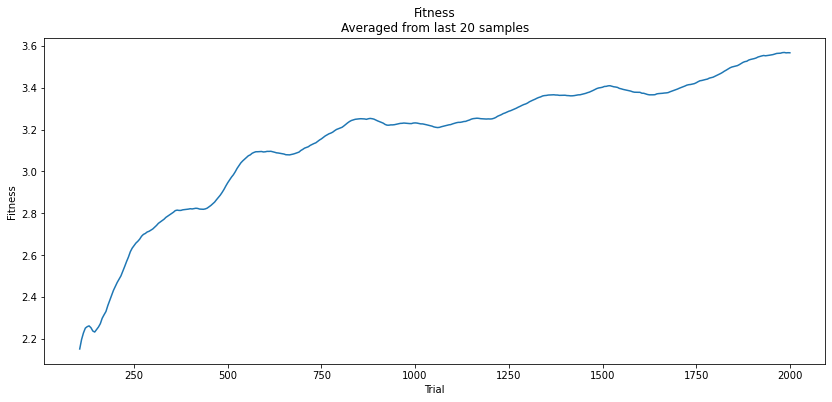

In [164]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['avg_fitness'].rolling(window=avg_window).mean().plot();
ax.set_title(f'Fitness\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Fitness')

plt.show()

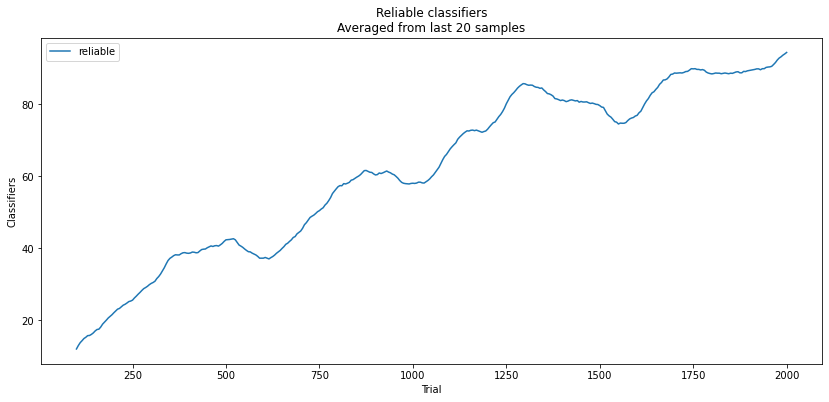

In [165]:
fig, ax = plt.subplots(figsize=figsize)

# metrics_df['population'].rolling(window=avg_window).mean().plot(label='population', ax=ax)
metrics_df['reliable'].rolling(window=avg_window).mean().plot(label='reliable', ax=ax)

ax.set_title(f'Reliable classifiers\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')

plt.legend()
plt.show()

## Exploitation

In [166]:
%%time

agent = ACS2ER(cfg, population_explore)
metrics_exploit = agent.exploit(wrapped, 200)
population_exploit = agent.population

INFO:lcs.agents.Agent:{'trial': 20, 'steps_in_trial': 57, 'reward': 1.0, 'perf_time': 0.2562841999997545, 'avg_fitness': 3.5839557411083205, 'population': 1535, 'numerosity': 1535, 'reliable': 97}
INFO:lcs.agents.Agent:{'trial': 40, 'steps_in_trial': 27, 'reward': 1.0, 'perf_time': 0.0990922999999384, 'avg_fitness': 3.5960064007960786, 'population': 1535, 'numerosity': 1535, 'reliable': 97}
INFO:lcs.agents.Agent:{'trial': 60, 'steps_in_trial': 67, 'reward': 1.0, 'perf_time': 0.2963175999998384, 'avg_fitness': 3.606026405860157, 'population': 1535, 'numerosity': 1535, 'reliable': 97}
INFO:lcs.agents.Agent:{'trial': 80, 'steps_in_trial': 37, 'reward': 1.0, 'perf_time': 0.1740197000003718, 'avg_fitness': 3.6040270935555254, 'population': 1535, 'numerosity': 1535, 'reliable': 97}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 11, 'reward': 1.0, 'perf_time': 0.04287509999994654, 'avg_fitness': 3.61108863920825, 'population': 1535, 'numerosity': 1535, 'reliable': 97}
INFO:lcs.agents.

Wall time: 37.6 s


In [167]:
metrics_exploit_df = pd.DataFrame(metrics_exploit)
metrics_exploit_df.set_index('trial', inplace=True)

In [168]:
window = 5

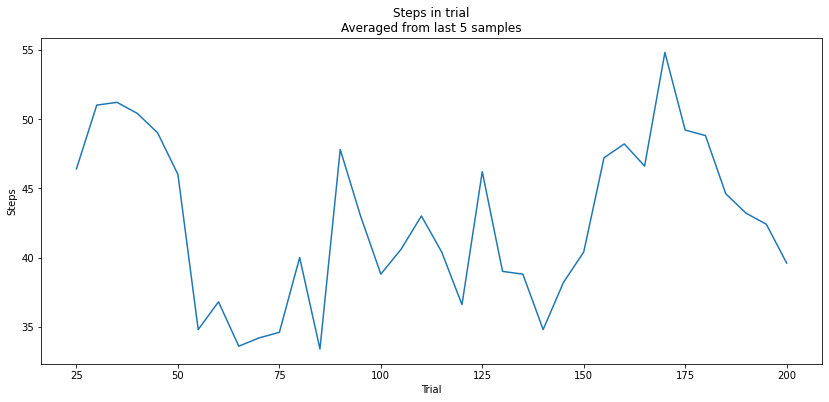

Avg steps 21.7425


In [169]:
fig, ax = plt.subplots(figsize=figsize)

metrics_exploit_df['steps_in_trial'].rolling(window=window).mean().plot();
ax.set_title(f'Steps in trial\nAveraged from last {window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Steps')

plt.show()

print(f"Avg steps {metrics_df['steps_in_trial'].mean()}")

In [170]:
for cl in sorted(population_exploit, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

#131 - L - #0## [q: 0.996, fit: 4.995, r: 5.01, ir: 1.00] (*)
9131 - L - #0## [q: 0.997, fit: 4.992, r: 5.01, ir: 1.00] 
9-131 - R - #0## [q: 0.954, fit: 4.763, r: 4.99, ir: 1.00] 
#-172 - L - ###3 [q: 0.968, fit: 4.564, r: 4.72, ir: 1.00] (*)
8071 - R - #### [q: 0.999, fit: 4.543, r: 4.55, ir: 1.00] 
9-172 - L - ###3 [q: 0.953, fit: 4.502, r: 4.72, ir: 1.00] 
9-173 - R - ###2 [q: 0.928, fit: 4.479, r: 4.83, ir: 1.00] 
9-152 - L - ##6# [q: 0.992, fit: 4.458, r: 4.50, ir: 1.00] 
#141 - L - #0## [q: 0.971, fit: 4.438, r: 4.57, ir: 1.00] (*)
9-163 - L - ##7# [q: 1.000, fit: 4.430, r: 4.43, ir: 1.00] 
9030 - L - ###1 [q: 0.875, fit: 4.425, r: 5.06, ir: 1.00] 
9#73 - L - #### [q: 1.000, fit: 4.410, r: 4.41, ir: 1.00] 
9-173 - L - #### [q: 1.000, fit: 4.409, r: 4.41, ir: 1.00] 
10151 - R - #### [q: 0.970, fit: 4.399, r: 4.54, ir: 1.00] 
#-163 - L - ##7# [q: 0.990, fit: 4.373, r: 4.42, ir: 1.00] (*)
9031 - R - #1#0 [q: 0.869, fit: 4.358, r: 5.01, ir: 1.00] 
9141 - L - #0## [q: 0.949, fit: 4.3